<a href="https://colab.research.google.com/github/HuangJin-De/Machine-Learning-in-Atmospheric-Thermodynamics/blob/master/hw03/hw03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! rm -rf Machine-Learning-in-Atmospheric-Thermodynamics
! git clone https://github.com/HuangJin-De/Machine-Learning-in-Atmospheric-Thermodynamics.git



Cloning into 'Machine-Learning-in-Atmospheric-Thermodynamics'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (315/315), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 347 (delta 110), reused 204 (delta 47), pack-reused 32
Receiving objects: 100% (347/347), 180.07 MiB | 44.84 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split

path='Machine-Learning-in-Atmospheric-Thermodynamics/hw03'
filen=path+'/data/era5_stn_th.dat'

data=np.fromfile(filen,dtype=np.float32)
data=data.reshape(-1,17)

x=data[:,0:16]
y=data[:,16].reshape(-1,1)

print(x.shape,x[1,:])
print(y.shape,y[1,:])

x_temp,x_valid,y_temp,y_valid=train_test_split(x,y,test_size=0.2,random_state=1)
x_train,x_test,y_train,y_test=train_test_split(x_temp,y_temp,test_size=0.2,random_state=1)

scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)
x_valid=scaler.transform(x_valid)

print('finished')

(9417, 16) [326.37604 323.53775 320.28677 317.47955 315.22504 312.1862  310.70364
 309.3074  307.98483 306.47357 305.08533 303.91504 302.85    301.75815
 300.15994 299.9878 ]
(9417, 1) [0.]
finished


In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

class TrainData(Dataset):
    
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.x_data)

train_data=TrainData(torch.FloatTensor(x_train),torch.FloatTensor(y_train))
test_data=TrainData(torch.FloatTensor(x_test),torch.FloatTensor(y_test))
valid_data=TrainData(torch.FloatTensor(x_valid),torch.FloatTensor(y_valid))

BATCH_SIZE=64
train_loader=DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)
test_loader=DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=True)
valid_loader=DataLoader(dataset=valid_data,batch_size=1)

print('finished')

finished


In [4]:
from torch import nn
from torchvision.transforms import ToTensor, Lambda, Compose
import time

class BinaryClassification(nn.Module):
  def __init__(self):
    super(BinaryClassification, self).__init__()
    self.BC = nn.Sequential(
      nn.Linear(16, 128),   
      nn.ReLU(),     
      nn.BatchNorm1d(128),   
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.BatchNorm1d(128),
      nn.Dropout(p=0.1),
      nn.Linear(128, 1)
    )

  def forward(self, x):
    freq = self.BC(x)
    binary = freq #torch.round(freq)
    return binary

print('defined model')

defined model


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = BinaryClassification().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train()
    train_loss=0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)  
        loss = loss_fn(pred, y) 
        train_loss += loss.item()

        optimizer.zero_grad()  
        loss.backward()      
        optimizer.step()      
       
        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches
    return train_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)

    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad(): 
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(torch.sigmoid(pred))==y).sum().float()

    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss

# training start
epochs=200

tt=time.time()
train_loss=[]
test_loss=[]
for t in range(epochs):
    print(f"Epoch {t+1}-------------------------------")
    loss = train(train_loader, model, loss_fn, optimizer)
    train_loss.append(loss)
    loss = test(test_loader, model, loss_fn)
    test_loss.append(loss)

elapse=time.time()-tt
print(elapse)

torch.save(model.state_dict(),'model.pkl')

Epoch 1-------------------------------
Accuracy: 56.1%, Avg loss: 0.689513
Epoch 2-------------------------------
Accuracy: 61.0%, Avg loss: 0.656414
Epoch 3-------------------------------
Accuracy: 64.3%, Avg loss: 0.632988
Epoch 4-------------------------------
Accuracy: 64.8%, Avg loss: 0.630090
Epoch 5-------------------------------
Accuracy: 67.2%, Avg loss: 0.610276
Epoch 6-------------------------------
Accuracy: 69.4%, Avg loss: 0.590285
Epoch 7-------------------------------
Accuracy: 69.2%, Avg loss: 0.593356
Epoch 8-------------------------------
Accuracy: 69.5%, Avg loss: 0.581750
Epoch 9-------------------------------
Accuracy: 70.0%, Avg loss: 0.582720
Epoch 10-------------------------------
Accuracy: 69.1%, Avg loss: 0.592813
Epoch 11-------------------------------
Accuracy: 69.6%, Avg loss: 0.579845
Epoch 12-------------------------------
Accuracy: 69.9%, Avg loss: 0.582851
Epoch 13-------------------------------
Accuracy: 70.0%, Avg loss: 0.580876
Epoch 14-------------

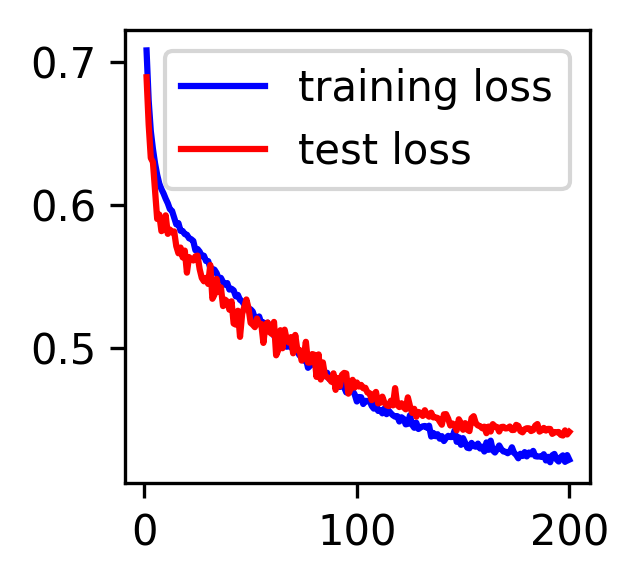

In [7]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(2,2),dpi=300)
ax.plot(np.arange(1,epochs+1),train_loss,'b',np.arange(1,epochs+1),test_loss,'r')
plt.legend(["training loss","test loss"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

Text(12.416666666666657, 0.5, 'True')

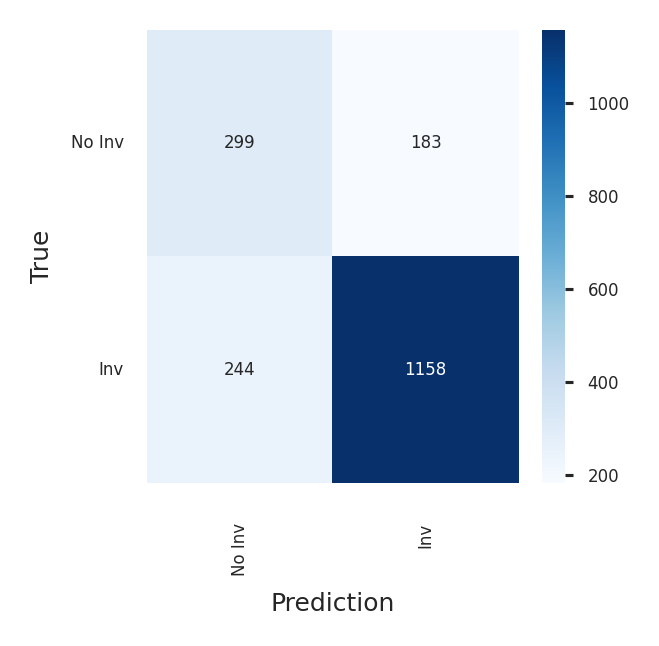

In [26]:
import seaborn as sn

model2 = BinaryClassification()
model2.load_state_dict(torch.load('model.pkl'))

classes = [
    "No Inv",
    "Inv"
]

model2.eval()

cm=np.zeros((len(classes),len(classes)))

test_loader=DataLoader(test_data,batch_size=1)
for x,y in valid_loader:
  pred = model2(x)
  pred = torch.round(torch.sigmoid(pred))
  x1=pred.detach().numpy().astype(np.int)
  y1=y.detach().numpy().astype(np.int)
  cm[x1,y1]+=1
  #print(f'預測值："{pred[0].argmax(0)}" / 實際值："{y[0]}"')

plt.rcParams.update({'ytick.major.size':2,'ytick.major.width':0.75})
fig,ax=plt.subplots(figsize=(2,2),dpi=300)
ax=sn.heatmap(cm,xticklabels=classes,yticklabels=classes,annot=True,cmap='Blues',fmt='g',annot_kws={"fontsize":4})

plt.yticks(rotation=0) 
plt.xticks(rotation=90)
sn.set(font_scale=0.5)
ax.tick_params(labelsize=4) 
ax.figure.axes[-1].tick_params(labelsize=4)
plt.xlabel('Prediction')
plt.ylabel('True')